In [1]:
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from qlib.data import D
from qlib.config import REG_CN
from qlib.contrib.data.handler import Alpha158
from qlib.data.filter import NameDFilter, ExpressionDFilter
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qlib.contrib.model.gbdt import LGBModel
from qlib.contrib.data.handler import Alpha158
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


In [3]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/day1_data_qlib', region=REG_CN)

[8876:MainThread](2025-04-27 09:04:55,708) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[8876:MainThread](2025-04-27 09:04:55,709) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[8876:MainThread](2025-04-27 09:04:55,716) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/day1_data_qlib')}


In [4]:
trade_date = D.calendar(start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day')
trade_date

array([Timestamp('2022-01-04 00:00:00'), Timestamp('2022-01-05 00:00:00'),
       Timestamp('2022-01-06 00:00:00'), Timestamp('2022-01-07 00:00:00'),
       Timestamp('2022-01-10 00:00:00'), Timestamp('2022-01-11 00:00:00'),
       Timestamp('2022-01-12 00:00:00'), Timestamp('2022-01-13 00:00:00'),
       Timestamp('2022-01-14 00:00:00'), Timestamp('2022-01-17 00:00:00'),
       Timestamp('2022-01-18 00:00:00'), Timestamp('2022-01-19 00:00:00'),
       Timestamp('2022-01-20 00:00:00'), Timestamp('2022-01-21 00:00:00'),
       Timestamp('2022-01-24 00:00:00'), Timestamp('2022-01-25 00:00:00'),
       Timestamp('2022-01-26 00:00:00'), Timestamp('2022-01-27 00:00:00'),
       Timestamp('2022-01-28 00:00:00'), Timestamp('2022-02-07 00:00:00'),
       Timestamp('2022-02-08 00:00:00'), Timestamp('2022-02-09 00:00:00'),
       Timestamp('2022-02-10 00:00:00'), Timestamp('2022-02-11 00:00:00'),
       Timestamp('2022-02-14 00:00:00'), Timestamp('2022-02-15 00:00:00'),
       Timestamp('2022-02

In [7]:
D.features(instruments = ['110038.SH'], fields = ['$close'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day')

$close
instrument datetime              
110038.SH  2022-01-04  150.570007
           2022-01-05  144.690002
           2022-01-06  147.009995
           2022-01-07  143.330002
           2022-01-10  142.199997
...                           ...
           2022-11-07  135.882004
           2022-11-08  134.332001
           2022-11-09  134.332001
           2022-11-10  134.332001
           2022-11-11  134.332001

[207 rows x 1 columns]

In [4]:
expressionDFilter = ExpressionDFilter(rule_expression='$volume!=0')
instruments = D.instruments(market = 'all', filter_pipe=[expressionDFilter])
# stock_list = D.list_instruments(instruments = instruments,
#                                 start_time='2022-01-01',
#                                 end_time='2025-03-31',
#                                 as_list=True)

In [5]:
# 5/95 Winsorize
def winsorize(s):
    lower = s.quantile(0.05)
    upper = s.quantile(0.95)
    s_winsorized = s.clip(lower, upper)
    return s_winsorized

In [118]:
# 将dataframe格式的因子数据表变为dict格式,
def factor_dict(factor):
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values().dropna()
    return factor_dict

In [112]:
# 计算因子每日分组收益率,N为分组数,factor为dict格式
def cal_group_return(factor, N):
    date_list = list(factor.keys())
    group_return={}
    if cal_RankIC_mean(factor) > 0:
        for date in date_list[:-1]:
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_open.shift(-1)/data_open-1).shift(-1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group'+str(N)] - stock_return['group1']
            stock_return['benchmark'] = (data_open.loc[:,stock_all].shift(-1)/data_open.loc[:,stock_all] - 1).shift(-1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    else:
        for date in date_list[:-1]:
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_open.shift(-1)/data_open-1).shift(-1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group1'] - stock_return['group'+str(N)]
            stock_return['benchmark'] = (data_open.loc[:,stock_all].shift(-1)/data_open.loc[:,stock_all] - 1).shift(-1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    return group_return

In [65]:
# 画出分组累积超额收益走势，factor为dict格式，N为组数
def plot_return(factor, N):
    group_return = cal_group_return(factor, N)
    group_cum_return = pd.DataFrame(group_return).T
    for i in range(1,N+1):
        group_cum_return['group'+str(i)] = group_cum_return['group'+str(i)] - group_cum_return['benchmark']
    group_cum_return.cumsum().iloc[:,:N+1].plot()

In [9]:
# 计算年化收益率，factor为dict格式，N为组数
def cal_annual_return(factor, N):
    return (pd.DataFrame(cal_group_return(factor, N)).T).mean() * 252

In [92]:
# 计算每日IC值，factor为dict格式
def cal_IC(factor):
   factor_df = pd.DataFrame(factor)
   return factor_df.corrwith((data_open.shift(-1)/data_open-1).shift(-1).T).dropna()

In [11]:
# 计算每日IC均值，factor为dict格式
def cal_IC_mean(factor):
    IC = cal_IC(factor).mean()
    return IC

In [12]:
# 计算每日RankIC值，factor为dict格式
def cal_RankIC(factor):
   factor = pd.DataFrame(factor)
   return factor.corrwith((data_open.shift(-1)/data_open-1).shift(-1).T, method = 'spearman')

In [13]:
# 计算每日RankIC均值，factor为dict格式
def cal_RankIC_mean(factor):
    RankIC = cal_RankIC(factor).mean()
    return RankIC

In [14]:
# 计算日度RankICIR值，factor为dict格式
def cal_RankICIR(factor):
    RankIC = cal_RankIC(factor)
    ICIR = RankIC.mean() / RankIC.std()
    return ICIR

In [15]:
# 计算日度胜率,factor为dict格式,N为组数
def cal_winrate(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T
    return (group_return > 0).sum() / len(group_return.index)
    

In [40]:
# 计算最大回撤，factor为dict格式，N为组数
def cal_MDD(factor, N):
    group_return = cal_group_return(factor, N)
    DD = (pd.DataFrame(group_return).T + 1).cumprod() - (pd.DataFrame(group_return).T + 1).cumprod().cummax()
    MDD = np.abs(DD).max()
    return MDD
    

In [16]:
# 计算分组累积超额收益,factor为dict格式,N为组数
def cal_alpha(factor, N):
    group_return = cal_group_return(factor, N)
    group_return = pd.DataFrame(group_return).T
    group_return_cumprod = (group_return + 1).cumprod()
    excess_Return = group_return_cumprod.sub(group_return_cumprod['benchmark'], axis = 0)
    return excess_Return.iloc[:,:-1]
    

In [17]:
# 计算多头年化超额,factor为dict格式，N为组数
def cal_long_return(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.mean() * 252
        return long

In [18]:
# 计算多头超额胜率,factor为dict格式，N为组数
def cal_long_winrate(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate

In [19]:
# 计算年化夏普比率,factor为dict格式，N为组数，rate为无风险利率
def cal_sharp(factor, N, rate=0.02):
    annual_return = cal_annual_return(factor, N) - rate
    std = pd.DataFrame(cal_group_return(factor, N)).T.std() * math.sqrt(252)
    sharp = annual_return / std 
    return sharp

In [20]:
# 计算概率，factor为dict格式，N为组数
def cal_probability(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T.iloc[:,:-1]
    group_return = group_return.rolling(20).sum().dropna(how = 'all')
    group_cols = [col for col in group_return.columns[:N]]
    if cal_RankIC_mean(factor) < 0:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[0]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] >= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    else:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[0]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] <= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    n = len(group_return.index)
    p0, p1, p2, p3 = group_return['概率0'].sum()/n, group_return['概率1'].sum()/n, group_return['概率2'].sum()/n, group_return['概率3'].sum()/n
    return pd.Series([p0,p1,p2,p3],index = ['概率0','概率1','概率2','概率3'])


In [21]:
# 分池，factor为dataframe格式
def cal_pool_factor(factor):
    mark = pd.read_csv('C:/Users/tantra/Desktop/CBStyleMark.csv', parse_dates=['date'])
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    pools = ['GP','ZP','DP']
    for pool in pools:
        if pool == 'GP':
            factor_day_GP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['GP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_GP[date] = factor_dict[date].loc[pool_stocklist].dropna().sort_values()
        if pool == 'ZP':
            factor_day_ZP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['ZP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_ZP[date] = factor_dict[date].loc[pool_stocklist].dropna().sort_values()
        if pool == 'DP':
            factor_day_DP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['DP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_DP[date] = factor_dict[date].loc[pool_stocklist].dropna().sort_values()
    return factor_day_GP,factor_day_ZP,factor_day_DP

In [25]:
# 因子分析，factor为dataframe格式，N为组数
def factor_analyse(factor):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额', '多头超额胜率', '多空夏普比率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc[pd.to_datetime('2025-01-01'):pd.to_datetime('2025-03-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df
    
                                                                       



In [22]:
data_close = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_close

instrument,110038.SH,110043.SH,110044.SH,110045.SH,110047.SH,110048.SH,110052.SH,110053.SH,110055.SH,110056.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-04,150.570007,122.300003,206.880005,118.949997,122.070000,246.820007,118.250000,120.550003,204.940002,135.229996,...,127.000000,156.000000,116.560997,118.000000,164.000000,130.300003,123.697998,129.990005,142.009995,143.660995
2022-01-05,144.690002,123.970001,208.020004,119.779999,122.169998,236.690002,119.540001,121.580002,205.139999,134.250000,...,125.000000,154.520996,116.809998,117.885002,161.210007,144.009995,124.699997,128.880005,140.110992,140.139999
2022-01-06,147.009995,123.940002,205.300003,119.809998,122.519997,225.630005,114.129997,121.440002,204.080002,135.839996,...,124.130997,151.800003,118.212997,117.989998,161.000000,145.367004,126.080002,130.899994,142.169998,142.259995
2022-01-07,143.330002,124.480003,206.070007,119.010002,123.940002,222.000000,114.800003,122.019997,197.070007,135.800003,...,125.000000,150.042999,118.323997,119.000000,159.600006,143.604004,124.970001,130.298996,145.789993,140.190002
2022-01-10,142.199997,125.589996,204.270004,119.010002,123.870003,217.990005,114.800003,123.489998,196.100006,136.119995,...,125.489998,150.100006,118.870003,126.000000,158.880005,145.699997,125.000000,130.250000,145.927002,140.850006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.252998,117.011002,125.448997,NaN,NaN,130.003998,120.769997,NaN,131.263000,NaN
2025-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.571999,117.300003,125.705002,NaN,NaN,130.029999,122.276001,NaN,130.210007,NaN
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.442001,117.139000,125.890999,NaN,NaN,130.675003,122.278999,NaN,135.500000,NaN


In [23]:
data_open = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_open

instrument,110038.SH,110043.SH,110044.SH,110045.SH,110047.SH,110048.SH,110052.SH,110053.SH,110055.SH,110056.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-04,145.990005,120.620003,205.500000,117.379997,119.750000,253.699997,111.389999,119.870003,204.199997,133.869995,...,126.599998,157.929993,115.150002,117.146004,162.110001,129.348007,122.500999,128.115997,141.500000,143.380005
2022-01-05,151.000000,122.260002,206.009995,119.269997,122.980003,248.000000,118.300003,120.550003,204.970001,135.500000,...,127.014999,156.598999,116.599998,118.472000,162.610001,143.330002,123.886002,130.203003,140.880005,143.940002
2022-01-06,142.130005,123.970001,209.000000,119.900002,121.900002,236.029999,119.000000,122.000000,205.139999,134.089996,...,124.430000,154.923004,116.810997,118.053001,159.839996,136.000000,124.698997,128.309998,140.399994,139.559998
2022-01-07,145.300003,124.459999,206.000000,119.900002,123.279999,226.289993,113.660004,121.309998,205.000000,135.029999,...,124.339996,152.184998,118.400002,118.400002,160.630005,144.899994,125.324997,131.270996,141.817001,142.632996
2022-01-10,143.770004,125.000000,206.589996,119.099998,124.300003,222.000000,114.559998,122.400002,197.779999,135.800003,...,124.709999,149.938004,118.585999,126.000000,158.240005,144.485992,124.949997,129.500000,145.000000,139.899994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.099998,117.099998,125.139999,NaN,NaN,131.671005,120.329002,NaN,127.417000,NaN
2025-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.207001,117.045998,125.470001,NaN,NaN,130.175995,120.949997,NaN,131.442001,NaN
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.599998,117.300003,125.560997,NaN,NaN,129.770004,122.300003,NaN,130.095993,NaN


In [24]:
ret5 = (data_close / data_close.shift(5) -1).dropna(how = 'all')
ret5

instrument,110038.SH,110043.SH,110044.SH,110045.SH,110047.SH,110048.SH,110052.SH,110053.SH,110055.SH,110056.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-11,-0.054858,0.027473,-0.006622,0.005801,0.004833,-0.134065,-0.010909,0.031107,-0.060896,0.005694,...,-0.020197,-0.059359,0.019209,0.069068,-0.051829,0.108289,0.010445,0.007000,0.046243,-0.027572
2022-01-12,-0.019421,0.017101,-0.012643,-0.002254,0.008349,-0.062487,-0.012213,0.029363,-0.051185,0.011620,...,0.013592,0.004873,0.018389,0.077067,-0.026115,-0.007361,-0.001604,0.022657,0.063086,0.030184
2022-01-13,-0.053602,0.011538,-0.002728,-0.004924,0.004407,-0.048619,0.013932,0.029068,-0.055566,-0.007730,...,0.006719,-0.001976,0.004898,0.076091,-0.055901,-0.025879,-0.012532,-0.001765,0.031828,0.020666
2022-01-14,-0.029722,-0.003454,-0.024846,-0.013528,-0.026545,-0.043198,-0.006620,0.002787,-0.035419,-0.003535,...,-0.000320,0.013709,-0.011190,0.067059,-0.058841,-0.014651,-0.014804,0.010737,-0.019137,0.021471
2022-01-17,-0.021660,-0.015766,-0.013756,-0.013444,-0.028498,-0.025414,0.017683,-0.012714,-0.023355,0.013371,...,-0.001195,0.058627,-0.010768,0.025230,-0.002392,0.008236,-0.008008,0.019570,-0.020058,0.020092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.018311,-0.031927,-0.007900,NaN,NaN,-0.062967,-0.027374,NaN,-0.015946,NaN
2025-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005575,-0.020868,0.000048,NaN,NaN,-0.044950,-0.006492,NaN,-0.006637,NaN
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001347,-0.018032,0.002317,NaN,NaN,-0.008054,-0.005498,NaN,0.047108,NaN


In [109]:
factor_analyse(ret5)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.126205 -0.147705 -0.174627 -0.262373 -0.102726 -0.028992   
多头年化超额   -0.052586  0.015209  0.015373  0.119869 -0.054030 -0.011806   
多头超额胜率    0.480447  0.508380  0.516760  0.580645  0.467742  0.548387   
多空夏普比率   -0.402729  0.708902  0.377011  1.891721 -0.181040 -0.780627   
概率1       0.401180  0.530973  0.492625  0.733333  0.457143  0.352381   
概率2       0.235988  0.353982  0.436578  0.638095  0.247619  0.352381   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.113272 -0.413311 -0.452684  
多头年化超额   -0.150955  0.119838  0.050717  
多头超额胜率    0.428571  0.535714  0.517857  
多空夏普比率   -1.708456  3.770756  2.646515  
概率1       0.194444  0.583333  0.861111  
概率2       0.055556  0.916667  0.611111

In [41]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5)

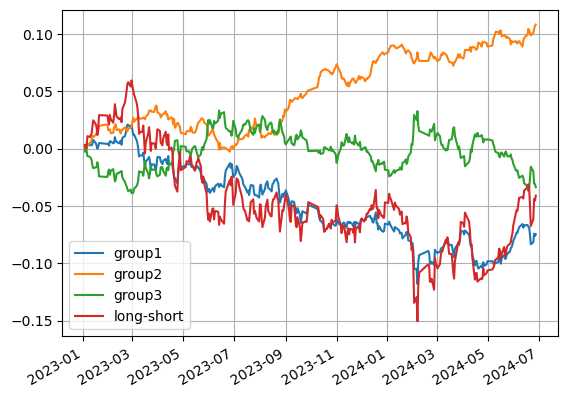

In [111]:
# 样本内
ret5_sample = ret5.loc[pd.to_datetime('2023-01-01') : pd.to_datetime('2024-06-30')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_sample)
plot_return(factor_gp, 3)
#plot_return(factor_zp, 4)
#plot_return(factor_dp, 3)
plt.grid(True)

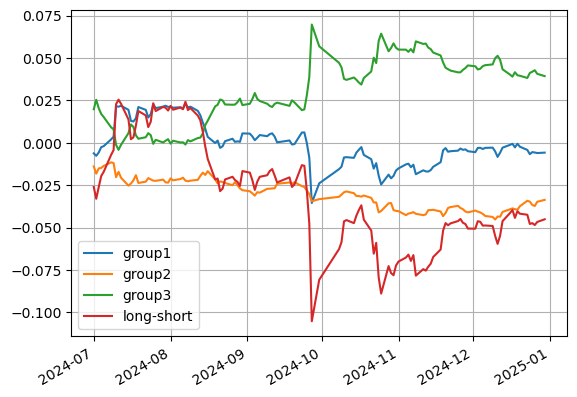

In [71]:
# 样本外
#ret5_test = ret5.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
#factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#plot_return(factor_gp, 3)
#plot_return(factor_zp, 4)
plot_return(factor_dp, 3)
plt.grid(True)

In [78]:
data_open.to_parquet("C:/Users/tantra/Desktop/open.parquet", engine="pyarrow")

In [85]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5)

In [113]:
ret5

instrument,110038.SH,110043.SH,110044.SH,110045.SH,110047.SH,110048.SH,110052.SH,110053.SH,110055.SH,110056.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-11,-0.054858,0.027473,-0.006622,0.005801,0.004833,-0.134065,-0.010909,0.031107,-0.060896,0.005694,...,-0.020197,-0.059359,0.019209,0.069068,-0.051829,0.108289,0.010445,0.007000,0.046243,-0.027572
2022-01-12,-0.019421,0.017101,-0.012643,-0.002254,0.008349,-0.062487,-0.012213,0.029363,-0.051185,0.011620,...,0.013592,0.004873,0.018389,0.077067,-0.026115,-0.007361,-0.001604,0.022657,0.063086,0.030184
2022-01-13,-0.053602,0.011538,-0.002728,-0.004924,0.004407,-0.048619,0.013932,0.029068,-0.055566,-0.007730,...,0.006719,-0.001976,0.004898,0.076091,-0.055901,-0.025879,-0.012532,-0.001765,0.031828,0.020666
2022-01-14,-0.029722,-0.003454,-0.024846,-0.013528,-0.026545,-0.043198,-0.006620,0.002787,-0.035419,-0.003535,...,-0.000320,0.013709,-0.011190,0.067059,-0.058841,-0.014651,-0.014804,0.010737,-0.019137,0.021471
2022-01-17,-0.021660,-0.015766,-0.013756,-0.013444,-0.028498,-0.025414,0.017683,-0.012714,-0.023355,0.013371,...,-0.001195,0.058627,-0.010768,0.025230,-0.002392,0.008236,-0.008008,0.019570,-0.020058,0.020092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.018311,-0.031927,-0.007900,NaN,NaN,-0.062967,-0.027374,NaN,-0.015946,NaN
2025-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005575,-0.020868,0.000048,NaN,NaN,-0.044950,-0.006492,NaN,-0.006637,NaN
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001347,-0.018032,0.002317,NaN,NaN,-0.008054,-0.005498,NaN,0.047108,NaN


In [119]:
factor_dict(ret5)

{Timestamp('2022-01-11 00:00:00'): instrument
 128050.SZ   -0.212880
 113051.SH   -0.194007
 123022.SZ   -0.180099
 123070.SZ   -0.161391
 113582.SH   -0.134778
                ...   
 113620.SH    0.103065
 128062.SZ    0.108019
 128141.SZ    0.108289
 113601.SH    0.121156
 127007.SZ    0.125390
 Name: 2022-01-11 00:00:00, Length: 375, dtype: float32,
 Timestamp('2022-01-12 00:00:00'): instrument
 128030.SZ   -0.124411
 123022.SZ   -0.114190
 113051.SH   -0.108427
 128017.SZ   -0.095528
 113582.SH   -0.075056
                ...   
 113626.SH    0.103060
 128062.SZ    0.104249
 113601.SH    0.104621
 128091.SZ    0.227098
 127007.SZ    0.380282
 Name: 2022-01-12 00:00:00, Length: 376, dtype: float32,
 Timestamp('2022-01-13 00:00:00'): instrument
 128111.SZ   -0.151592
 123022.SZ   -0.147968
 113051.SH   -0.143541
 128030.SZ   -0.128125
 128046.SZ   -0.111443
                ...   
 113550.SH    0.079082
 123078.SZ    0.090648
 128036.SZ    0.093750
 128039.SZ    0.117534
 127007.SZ  

In [89]:
# 每日IC值（分池）,factor为dataframe格式
def cal_IC_pool(factor):
    factor_gp, factor_zp, factor_dp = cal_pool_factor(factor)
    gp = cal_IC(factor_gp)
    zp = cal_IC(factor_zp)
    dp = cal_IC(factor_dp)
    return pd.concat([gp,zp,dp], keys = ['高平池', '中平池', '低平池'], axis = 1)

In [108]:
cal_IC_pool(ret5)

,高平池,中平池,低平池
2022-01-11,0.039383,-0.258928,-0.150688
2022-01-12,-0.035730,0.069066,-0.185610
2022-01-13,0.057563,-0.171536,0.152889
2022-01-14,-0.095078,-0.011548,-0.074600
2022-01-17,-0.182827,-0.138643,-0.145826
...,...,...,...
2025-03-21,0.036440,-0.158920,0.054850
2025-03-24,0.206954,0.000678,-0.261299
2025-03-25,-0.081884,-0.074254,-0.192800
2025-03-26,-0.341350,0.342849,-0.026351


In [114]:
# 每日分组收益（分池）,factor为dataframe格式
def cal_group_pool_cum(factor):
    factor_gp, factor_zp, factor_dp = cal_pool_factor(factor)
    gp = pd.DataFrame(cal_group_return(factor_gp, 3)).T.iloc[:,:3]
    zp = pd.DataFrame(cal_group_return(factor_zp, 4)).T.iloc[:,:4]
    dp = pd.DataFrame(cal_group_return(factor_dp, 3)).T.iloc[:,:3]
    return pd.concat([gp, zp, dp], keys = ['高平池', '中平池', '低平池'], axis = 1).dropna()

In [115]:
cal_group_pool_cum(ret5)

高平池                           中平池                      \
              group1    group2    group3    group1    group2    group3   
2022-01-11  0.030585  0.013295  0.023031  0.011033  0.003811  0.004171   
2022-01-12 -0.026845 -0.016268 -0.006899 -0.010245 -0.005738 -0.006798   
2022-01-13  0.001771 -0.004825  0.007826 -0.005413 -0.009888 -0.009685   
2022-01-14  0.028938  0.015028  0.012668  0.014141  0.010688  0.009329   
2022-01-17 -0.010895 -0.002965 -0.014233  0.003162  0.002480 -0.002987   
...              ...       ...       ...       ...       ...       ...   
2025-03-21 -0.017149 -0.012243 -0.009932 -0.008684 -0.006214 -0.006184   
2025-03-24 -0.012292  0.001687 -0.002648  0.003831  0.003453  0.004127   
2025-03-25  0.013690  0.008514  0.008934  0.004832  0.005784  0.004296   
2025-03-26  0.003807  0.002112 -0.010716 -0.000515  0.001954 -0.000453   
2025-03-27 -0.012857 -0.012981 -0.012549 -0.009064 -0.005627 -0.006158   

                           低平池                      
              group4    group1    group2    group3  
2022-01-11  0.000029  0.003457  0.003187 -0.000544  
2022-01-12 -0.006631 -0.004121 -0.005283 -0.006299  
2022-01-13 -0.010936 -0.012218 -0.014489 -0.012647  
2022-01-14  0.015447  0.008995  0.010117  0.006658  
2022-01-17 -0.003880  0.004228 -0.000527 -0.000619  
...              ...       ...       ...       ...  
2025-03-21 -0.010359 -0.006019 -0.005609 -0.005107  
2025-03-24  0.003024  0.005685  0.003846  0.000710  
2025-03-25  0.002527  0.004608  0.003010  0.002308  
2025-03-26  0.002503  0.002420  0.003191  0.001269  
2025-03-27 -0.005790 -0.002316 -0.001860 -0.004664  

[776 rows x 10 columns]

In [116]:
cal_group_pool_cum(ret5).to_parquet("C:/Users/tantra/Desktop/group_ret_daily.parquet", engine="pyarrow")